# Fit rectangle

Of the remaining vectorised mammade surface polygon cherck if these can accommodate a car sized rectangle aligned with their roadside linestring intersection

## Rectangle fitting resources

http://cgm.cs.mcgill.ca/~athens/cs507/Projects/2003/DanielSud/

https://gis.stackexchange.com/questions/59215/how-to-find-the-maximum-area-rectangle-inside-a-convex-polygon

https://stackoverflow.com/questions/2478447/find-largest-rectangle-containing-only-zeros-in-an-n%C3%97n-binary-matrix

https://community.safe.com/s/question/0D54Q000080heQVSAY/maximum-inside-rectangle-from-an-polygon

https://kam.mff.cuni.cz/~hansraj/publications/rectangle.pdf

https://mathoverflow.net/questions/105837/get-largest-inscribed-rectangle-of-a-concave-polygon

https://d3plus.org/blog/behind-the-scenes/2014/07/08/largest-rect/

https://dash.harvard.edu/bitstream/handle/1/27030936/tr-22-95.pdf?sequence=1

http://datagenetics.com/blog/march12014/index.html

Shapely functions
 - parallel_offset
https://shapely.readthedocs.io/en/latest/manual.html#object.parallel_offset

## Libraries

In [1]:
import pickle #no idea what this is, but apparently I installed it
import cv2

import os
from os import path
import glob
import sys
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

%matplotlib inline
pd.set_option('display.max_column', 100) #set max number of cols to display before ...

#check correct environment is being used: parkprov
print(sys.executable)

import rasterio
from rasterio._base import gdal_version
#https://rasterio.readthedocs.io/en/latest/
import rasterio.warp
import rasterio.features
from rasterio import plot #essential to plot images in BNG, in correct position, and full RGB 
from rasterio.mask import mask

import folium
import fiona
import pyproj
import shapely as shp
from shapely.ops import linemerge
from shapely.ops import unary_union

/Users/tamsinforbes/anaconda3/envs/parkprov/bin/python


## Read in files

In [2]:
dhvms = pd.read_csv(
    "../data/dhvms.csv"
    , dtype={'TOID': object, 'geometry': object})
#### convert WKT strings to geometry
dhvms['geometry'] = dhvms['geometry'].map(shp.wkt.loads)
#### convert to geodataframe and set CRS
dhvms = gpd.GeoDataFrame(dhvms, crs="EPSG:27700", geometry="geometry")

In [3]:
rsls = pd.read_csv(
    "../data/rsls24.csv"
    , dtype={'TOID': object, 'geometry': object, 'rslsLength': np.float64})
#### convert WKT strings to geometry
rsls['geometry'] = rsls['geometry'].map(shp.wkt.loads)
#### convert to geodataframe and set CRS
rsls = gpd.GeoDataFrame(rsls, crs="EPSG:27700", geometry="geometry")

In [4]:
#this is the left join of rsls24 and dhvms - not sure this useful
#difficult to work with GDF with more than one geometry column
#have to keep changing which one is the active one
data = pd.read_csv(
    "../data/ppp13data.csv"
    , dtype={'TOID': object, 'geometry_rsls': object, 'rslsLength': np.float64, 'geometry_vms': object})
#### convert WKT strings to geometry
data['geometry_rsls'] = data['geometry_rsls'].map(shp.wkt.loads)
data['geometry_vms'] = data['geometry_vms'].map(shp.wkt.loads)

#### convert to geodataframe and set CRS
data = gpd.GeoDataFrame(data, crs="EPSG:27700", geometry="geometry_vms")

In [5]:
#Load cropped gardens
#cg: cropped gardens
#read in as strings
cg = pd.read_csv("../data/cropped_gardens.csv"
                 , dtype={'gdnTOID': object, 'geometry': object})
#convert WKT strings to geometry
cg['geometry'] = cg['geometry'].map(shp.wkt.loads)
#convert to geodataframe and set CRS
cg = gpd.GeoDataFrame(cg, crs="EPSG:27700", geometry="geometry")

In [8]:
#geometry validity check
print("number of invalid rows: ", dhvms[ dhvms['geometry'].is_valid == False ].shape[0])
print("number of invalid rows: ", rsls[ rsls['geometry'].is_valid == False ].shape[0])
print("number of invalid rows: ", cg[ cg['geometry'].is_valid == False ].shape[0])


number of invalid rows:  0
number of invalid rows:  0
number of invalid rows:  0


In [9]:
cg.head()

gdnTOID                                           geometry
0  0001000003513170  POLYGON ((519327.150 180219.550, 519329.100 18...
1  1000001778258479  POLYGON ((519684.949 180970.923, 519685.728 18...
2  1000001778258579  POLYGON ((519666.761 180968.013, 519667.537 18...
3  1000001778258580  POLYGON ((519693.713 180972.325, 519694.467 18...
4  1000001778258608  POLYGON ((519712.133 180975.268, 519712.903 18...

In [10]:
dhvms.head()

TOID                                           geometry
0  0001000003513170  POLYGON ((519329.000 180221.500, 519329.000 18...
1  1000001778258479  POLYGON ((519691.000 180972.500, 519691.000 18...
2  1000001778258579  POLYGON ((519675.500 180970.000, 519675.500 18...
3  1000001778258580  POLYGON ((519700.500 180974.000, 519700.500 18...
4  1000001778258608  POLYGON ((519717.500 180976.500, 519717.500 18...

In [11]:
rsls.head()

TOID                                           geometry  \
0  1000001778697829  LINESTRING (519563.150 180927.100, 519566.950 ...   
1  1000001778697829  LINESTRING (519573.000 180928.575, 519578.400 ...   
2  5000005138038971  LINESTRING (519676.600 180894.800, 519687.900 ...   
3  1000001778697815  LINESTRING (519607.400 180867.900, 519610.000 ...   
4  1000001778697815  LINESTRING (519610.051 180872.000, 519610.600 ...   

   rslsLength  
0    5.407596  
1    5.462707  
2   14.634890  
3    4.789100  
4    5.994367

In [12]:
dhvms.crs == rsls.crs == data.crs

True

In [13]:
dhvms.nunique()

TOID        971
geometry    971
dtype: int64

In [14]:
rsls.nunique()

TOID           971
geometry      1055
rslsLength    1049
dtype: int64

In [15]:
rsls['geometry'].geom_type.value_counts()
#one row per line string, multiple rows per toid

LineString    1055
dtype: int64

In [16]:
dhvms['geometry'].geom_type.value_counts()
#one row per toid, polygon or multipolygon per toid

Polygon         949
MultiPolygon     22
dtype: int64

## Load rasters

In [6]:
#load TQ1980 APGB grids
path_rgb1980 = "../data/APEaling_111706_20200601/25cm_Aerial_Photo/111706-1_RGB_1_Shape/TQ1980.tif"
path_irg1980 = "../data/APGB_Ealing_InfraRedImagery/111803_20200707/50cm Colour Infrared/111803-1_CIR_1_Shape/TQ1980.tif"

#open
irg1980 = rasterio.open(path_irg1980)
rgb1980 = rasterio.open(path_rgb1980)


# Fit rectangle

- for each toid we have one or more vms polygons and one or more rsls linestrings
- for each toid and its linestring/s, polygon/s
    - create a linestring, ln, based on 2 points from the linestring 2.4m apart
    - buffer c to 4.8m with capped ends, resulting in rec, (buffer creates 2 car sized rectangles either side of ln and perpendicular to it).
    - (note only interested in one side of this; may think how to determine which side)
    - p: parking polygon: intersection of rec with toid vms polygon/s
    - calculate proportion of parking size rectangle 2.4 * 4.8 = 11.52 that intersects with vms
        - (area of p) / ( 11.52 ) 
    - calculate rec as proportion of vms: 
        - ( 11.52 ) / ( vms area )
    - or do inverse to give number of car parking spaces, if the area was the perfect shape
         - ( vms area ) / 11.52
         - if this is very large (definition) maybe can just assume parking?

bah


## Collect points sliding along

Maybe select points at 0.5m intervals. And stop when get a YES.



## Collect points from linestrings - interpolate attritbute

https://shapely.readthedocs.io/en/latest/manual.html#object.interpolate

Return a point at the specified distance along a linear geometric object.If the normalized arg is True, the distance will be interpreted as a fraction of the geometric object’s length.

### Collect 6 points, for 3 rectangle starting positions
Try to fit the rectangle with short edge on the linestring in three positions: 'left', middle, 'right. Left and right are determined by the order the linestring points are read in, so from which end interpolate uses as the beggining of the linestring. 

### Allowing an indent from the ends of the linestring
Use interpolate to collect a list of 6 points where each point is defined via interpolate form the following:
- index 0: distance = 0.5
- index 1: distance = 0.5 + 2.4 = 2.9
- index 2: distance = (length/2) - 1.2
- index 3: distance = (length/2) + 1.2
- index 4: distance = length - 2.9
- index 5: distance = length - 0.5

This would give the short end of 3 rectangles on the linestring where points 0&1 are the 'left' most position, 
- indices 0&1: 'left' most position
- indices 2&3: middle position
- indices 4&5: 'right' most position

I wanted to start just inside the ends of the linestring to account for rough edges? But the linestring comes from the original vector polygon, not the vectorised raster of manmade surface. And my shortest linestring is 2.4m (filtered for those >= 2.4m), so I'd better start/end at the ends of the linestring!!! 

### Not indent: start/end with ends of linestring
Points to collect are:
- 0: left start: 0
- 1: left end: 2.4
- 2: middle start: (length / 2) - 1.2
- 3: middle end: (length / 2) + 1.2
- 4: right start: length - 2.4
- 5: right end: length

In [17]:
test_toid = '1000001778697829'

#test_line is first linestring of 2 for this toid
test_line = rsls[rsls['TOID'] == test_toid]['geometry'][0]

print("test_line length: ", test_line.length)

test_pts = [
    test_line.interpolate(0)
    , test_line.interpolate(2.4)
    , test_line.interpolate(( test_line.length / 2 ) - 1.2)
    , test_line.interpolate(( test_line.length / 2 ) + 1.2)
    , test_line.interpolate( test_line.length - 2.4 )
    , test_line.interpolate( test_line.length )
]

for i in test_pts:
    print(list(i.coords))

test_line length:  5.407595504598106
[(519563.1500000004, 180927.0999999996)]
[(519565.5252496904, 180927.44378613945)]
[(519564.63828964415, 180927.3154103431)]
[(519567.01346444705, 180927.65969980668)]
[(519566.1265792879, 180927.5308206866)]
[(519568.5, 180927.8868995637)]


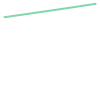

In [18]:
test_line

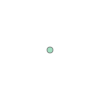

In [19]:
test_pts[0]

## Create a rectangle from collected points

Variables:
- r: type polygon, rectangle of unfixed orientation with sides length 2.4m and 4.8m
- l: type line, roadside linestring, may be multiple per TOID
- b: type polygon, buffered l
- m: types multi/polygon, dhvms multi/polygon, one per TOID
- p: type polygon, polygon of area of intersection between b and m


By TOID:
- create line from collected points: l
- buffer to 4.8m (this will buffer both sides): b
- intersect with dhvms polygon (m) to get polygon of overlap: p
- collect these values
    - p.area / r.area: proportion of parking rectangle area overlapping with m, ie how much of the car area fits in this position.
    - p.area / m.area: proportion of manmande surface that is occupied by overlap from the parking rectangle in this position. If this is very small, it suggests there may be lots of available space for a car to wiggle into.
     - ratio of these two: ( p.area / r.area) : ( p.area / m.area ). 
     
Although the final value reduces to (m.area / r.area) essentially a score of how many parking areas could fit in the manmade surface area, if it were the perfect shape. But reducing it to a quotient we lose the information that is how much of the parking rectangle fits. Maybe there is a way of retaining this information.

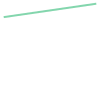

In [20]:
test_ls = shp.geometry.LineString([test_pts[0], test_pts[1]])
test_ls

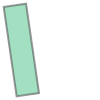

In [21]:
test_ls.buffer(distance = 4.8, cap_style = 2)

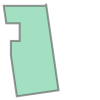

In [22]:
#https://shapely.readthedocs.io/en/latest/manual.html#object.intersection

test_p = (
    dhvms[dhvms['TOID'] == test_toid]['geometry']
    .intersection(test_ls.buffer(distance = 4.8, cap_style = 2))
)

#call value attribute and first index to get actual shape!
test_p.values[0]

In [23]:
#create gdf from single shapely polygon
d = {'geometry': [test_p.values[0]]}
test_gdf = gpd.GeoDataFrame(d, crs="EPSG:27700", geometry="geometry")

In [24]:
test_gdf

geometry
0  POLYGON ((519563.092 180927.500, 519565.000 18...

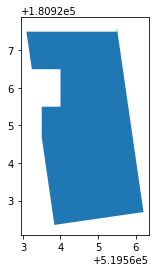

In [25]:
test_gdf.plot()

In [26]:
test_p_area = test_p.area.values[0]
test_p_area
#sqm

11.334938466701914

In [27]:
test_m_area = dhvms[dhvms['TOID'] == test_toid]['geometry'].area.values[0]
test_m_area
#sqm

98.25

In [29]:
#p.area / r.area
print("Proportion of rectangle area overlapping with manmade surface:"
      , ( test_p.area / (2.4 * 4.8) ).values[0])

#p.area / m.area
print("Proportion of manmade surface overlapped by parking rectangle: "
      ,  ( test_p.area / test_m_area ).values[0])

#1 - (p.area / m.area)
print("Proportion of remaining manmade surface: "
      , 1 - ( test_p.area / test_m_area ).values[0])

Proportion of rectangle area overlapping with manmade surface: 0.9839356307900967
Proportion of manmade surface overlapped by parking rectangle:  0.11536833044989225
Proportion of remaining manmade surface:  0.8846316695501077


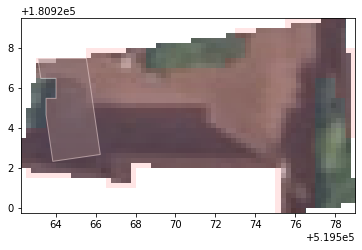

In [30]:
#get rgb image
grid = 'TQ1980'
rgb_path = '../jigsaw_output/rgb_gdn_cropped/' + grid + "_" + test_toid + '.tif'
rgb = rasterio.open(rgb_path)

base = test_gdf.plot(color = 'grey', edgecolor = 'white', alpha = 0.5)
dhvms[dhvms['TOID'] == test_toid].plot(ax = base, color = 'red', alpha = 0.1)

plot.show(rgb, ax = base)

## Check out multipolygons in dhvms

### In ppp13 the dissolve funciton created mulitpolygons 

Before the dissolve of holes **vms** contained only type POLYGON, but had multiple rows for some TOIDS.

Dissolving unconnected polygons with the same TOID creates a MULTIPOLYGON - think this will need to be exploded before trying to fit rectangles. Or try to build in to process, explode at that point.

In [34]:
dhvms['geometry'].geom_type.value_counts()
#one row per toid, polygon or multipolygon per toid

Polygon         949
MultiPolygon     22
dtype: int64

In [35]:
rsls['geometry'].geom_type.value_counts()


LineString    1055
dtype: int64

In [36]:
rsls.nunique()

TOID           971
geometry      1055
rslsLength    1049
dtype: int64

## Some multipolygons contain polygons with no rsls intersection

### Example

This is because I filtered the vms polygons for the list of TOIDs in the rsls list. But since TOID is not unique per polygon it include polygons without an intersecting linestring. I think if I explode the polygons then my method will just ignore these polygons.  

In [37]:
#create multipolygon list
mplist = dhvms[dhvms['geometry'].geom_type == "MultiPolygon"]['TOID'].tolist()

(180615, 180670)

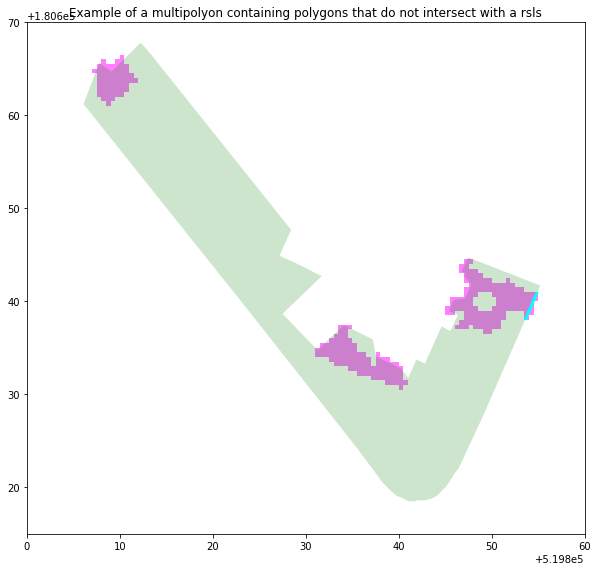

In [39]:

base = dhvms[ dhvms.TOID.isin(mplist[0:5]) ].plot(color = 'magenta', figsize = (10,10), alpha = 0.5)
rsls[ rsls.TOID.isin(mplist[0:5]) ].plot(ax = base, linewidth = 3, color = 'cyan')
cg[ cg.gdnTOID.isin(mplist[0:5]) ].plot(ax = base, color = 'green', alpha = 0.2)
base.set_title("Example of a multipolyon containing polygons that do not intersect with a rsls")
base.set_xlim(519800, 519860)
base.set_ylim(180615, 180670)

#think the image below is TOID 1000001778697935

In [40]:
dhvms[ dhvms.TOID.isin(mplist[0:5]) ]

TOID                                           geometry
21   1000001778697506  MULTIPOLYGON (((519944.000 180697.500, 519944....
50   1000001778697638  MULTIPOLYGON (((519589.000 180875.500, 519588....
69   1000001778697694  MULTIPOLYGON (((519977.500 180920.000, 519977....
111  1000001778697845  MULTIPOLYGON (((519523.000 180942.500, 519523....
153  1000001778697935  MULTIPOLYGON (((519833.500 180637.500, 519835....

In [41]:
rsls[ rsls.TOID.isin(mplist[0:5]) ]

TOID                                           geometry  \
397  1000001778697694  LINESTRING (519977.500 180919.603, 519992.400 ...   
552  1000001778697506  LINESTRING (519925.500 180706.400, 519925.900 ...   
553  1000001778697506  LINESTRING (519944.000 180697.013, 519945.900 ...   
644  1000001778697935  LINESTRING (519854.893 180641.000, 519853.580 ...   
666  1000001778697845  LINESTRING (519527.500 180937.297, 519521.900 ...   
860  1000001778697638  LINESTRING (519594.350 180875.750, 519589.550 ...   

     rslsLength  
397   20.463818  
552   16.574735  
553    3.359721  
644    3.275096  
666    5.656377  
860    8.241966

## Explode multipolygons

- exvms : one row per polygon, multiple rows for some TOIDs
- rsls: one row per linestring, multiple rows for some TOIDs

Bit confused
- got some TOIDs with multiple polygons
- any of these polygons may also have multiple linestring intersections

If I go by linestring in rsls what will happen?

In [42]:
exvms = dhvms.explode().reset_index(drop=True)

In [43]:
exvms.head()

TOID                                           geometry
0  0001000003513170  POLYGON ((519329.000 180221.500, 519329.000 18...
1  1000001778258479  POLYGON ((519691.000 180972.500, 519691.000 18...
2  1000001778258579  POLYGON ((519675.500 180970.000, 519675.500 18...
3  1000001778258580  POLYGON ((519700.500 180974.000, 519700.500 18...
4  1000001778258608  POLYGON ((519717.500 180976.500, 519717.500 18...

In [44]:
exvms[ exvms.TOID.isin(mplist[0:5]) ]

TOID                                           geometry
21   1000001778697506  POLYGON ((519944.000 180697.500, 519944.500 18...
22   1000001778697506  POLYGON ((519925.500 180706.500, 519926.500 18...
51   1000001778697638  POLYGON ((519589.000 180875.500, 519588.500 18...
52   1000001778697638  POLYGON ((519589.000 180875.500, 519590.000 18...
71   1000001778697694  POLYGON ((519977.500 180920.000, 519977.500 18...
72   1000001778697694  POLYGON ((519969.000 180918.000, 519969.000 18...
114  1000001778697845  POLYGON ((519523.000 180942.500, 519523.000 18...
115  1000001778697845  POLYGON ((519524.500 180946.500, 519524.500 18...
157  1000001778697935  POLYGON ((519833.500 180637.500, 519835.000 18...
158  1000001778697935  POLYGON ((519847.000 180644.500, 519848.000 18...
159  1000001778697935  POLYGON ((519810.000 180666.500, 519810.500 18...

In [45]:
exvms['geometry'].geom_type.value_counts()


Polygon    1001
dtype: int64

In [46]:
rsls.shape

(1055, 3)

In [47]:
rsls.head()

TOID                                           geometry  \
0  1000001778697829  LINESTRING (519563.150 180927.100, 519566.950 ...   
1  1000001778697829  LINESTRING (519573.000 180928.575, 519578.400 ...   
2  5000005138038971  LINESTRING (519676.600 180894.800, 519687.900 ...   
3  1000001778697815  LINESTRING (519607.400 180867.900, 519610.000 ...   
4  1000001778697815  LINESTRING (519610.051 180872.000, 519610.600 ...   

   rslsLength  
0    5.407596  
1    5.462707  
2   14.634890  
3    4.789100  
4    5.994367

## sjoin left rsls to exvms using 'within'

### This proved unhelpful 
- using 'intersection' the point interesection between the end of a linestring and a neighbouring polygon is included; which I do not wan!
- using 'within' then any linestring/polygon that happen to be aligned to the axes only share the boundary, so they intersect but the linestring is not within the polygon!  

sjoin to create link between each linestring and polygon
- if I sjoin rsls to exvms, I'll get multilinestrings, because some single polygons have more than one rsls
- if I sjoin exvms to rsls; this should be one row per linestring, with a polygon (maybe repeats of polygon), so one-many. I have certainly got more linestrings than polygons, I'll get repeat rows, because multiple linestrings may intersect with the same polygon. But I want to go by linestring and keep a check of whether TOID has already been tagged as 'parking potential'.

In [48]:
#sjoin left rsls, exvms; keep rsls 
#then these will have a common index?
#linestring polygon join
lsp = gpd.sjoin(
    left_df = rsls
    , right_df = exvms
    , how = 'left'
    , op = 'within' #use 'within' to avoid including polygons just touching the end of a neibouring linestring
)

In [49]:
lsp.shape

(1055, 5)

In [50]:
lsp.nunique()

TOID_left       971
geometry       1055
rslsLength     1049
index_right     984
TOID_right      970
dtype: int64

### Now I have a link between rsls index and exvms index

That is I have
- TOID_left and TOID_right which are identical
- index is that of rsls, and is unique
- index_right is the exvms index, linkng to the specific polygon that this line is within

In [51]:
lsp.head()

TOID_left                                           geometry  \
0  1000001778697829  LINESTRING (519563.150 180927.100, 519566.950 ...   
1  1000001778697829  LINESTRING (519573.000 180928.575, 519578.400 ...   
2  5000005138038971  LINESTRING (519676.600 180894.800, 519687.900 ...   
3  1000001778697815  LINESTRING (519607.400 180867.900, 519610.000 ...   
4  1000001778697815  LINESTRING (519610.051 180872.000, 519610.600 ...   

   rslsLength  index_right        TOID_right  
0    5.407596        105.0  1000001778697829  
1    5.462707        105.0  1000001778697829  
2   14.634890        976.0  5000005138038971  
3    4.789100         99.0  1000001778697815  
4    5.994367         99.0  1000001778697815

In [52]:
(lsp['TOID_left'] == lsp['TOID_right']).value_counts()

True     1054
False       1
dtype: int64

### One linestring not 'within' any polygon ???

It is aligned to the axes and so intersects but is not within... :o(

In [53]:
#linestring that is not 'within' any polygon ???
lsp[lsp['TOID_left'] != lsp['TOID_right']]

TOID_left                                           geometry  \
283  1000001778701747  LINESTRING (519178.500 180514.000, 519178.500 ...   

     rslsLength  index_right TOID_right  
283         2.5          NaN        NaN

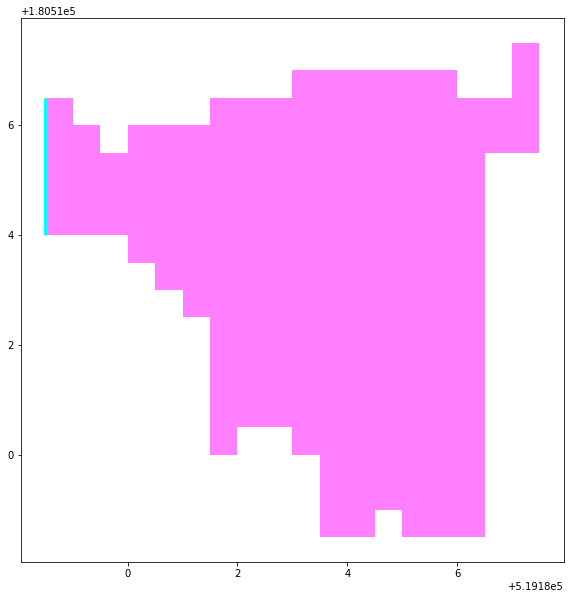

In [54]:
base = exvms[ exvms['TOID'] == '1000001778701747' ].plot(color = 'magenta', figsize = (10,10), alpha = 0.5)
rsls[ rsls['TOID'] == '1000001778701747' ].plot(ax = base, linewidth = 3, color = 'cyan')

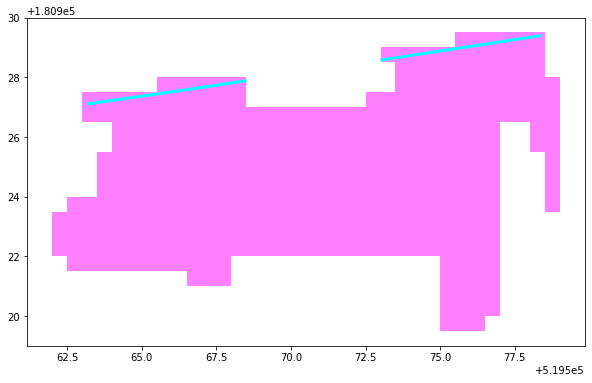

In [55]:
base = exvms[ exvms['TOID'] == '1000001778697829' ].plot(color = 'magenta', figsize = (10,10), alpha = 0.5)
rsls[ rsls['TOID'] == '1000001778697829' ].plot(ax = base, linewidth = 3, color = 'cyan')

## Loop through per linestring per TOID 

Use
- rsls
- exvms

can't use lsp, can't create link at gdf level, need to use intersects to include the rare occasion when garden and linestring are aligned to the axes, so the linestring only shares boundary with polygon, but this will also include neighbouring gardens. Can't see a way round it other than to group by TOID... 

- Don't know if you can first group by and then do a spatial join? then merge the output dfs into one????: NO sjoin does npt accept grouped object.





In [56]:
rsls.head()

TOID                                           geometry  \
0  1000001778697829  LINESTRING (519563.150 180927.100, 519566.950 ...   
1  1000001778697829  LINESTRING (519573.000 180928.575, 519578.400 ...   
2  5000005138038971  LINESTRING (519676.600 180894.800, 519687.900 ...   
3  1000001778697815  LINESTRING (519607.400 180867.900, 519610.000 ...   
4  1000001778697815  LINESTRING (519610.051 180872.000, 519610.600 ...   

   rslsLength  
0    5.407596  
1    5.462707  
2   14.634890  
3    4.789100  
4    5.994367

In [57]:
exvms.head()

TOID                                           geometry
0  0001000003513170  POLYGON ((519329.000 180221.500, 519329.000 18...
1  1000001778258479  POLYGON ((519691.000 180972.500, 519691.000 18...
2  1000001778258579  POLYGON ((519675.500 180970.000, 519675.500 18...
3  1000001778258580  POLYGON ((519700.500 180974.000, 519700.500 18...
4  1000001778258608  POLYGON ((519717.500 180976.500, 519717.500 18...

## Functon to collect 6 points from linestring

Takes a linestring shapely object outputs a list of 6 points that will make up 3 rectangles, from indices 0&1, 2&3, 4&5. Each pair is 2.4m apart

In [58]:
def six_pts(ls):
    pts = [
    ls.interpolate(0)
    , ls.interpolate(2.4)
    , ls.interpolate(( ls.length / 2 ) - 1.2)
    , ls.interpolate(( ls.length / 2 ) + 1.2)
    , ls.interpolate( ls.length - 2.4 )
    , ls.interpolate( ls.length )]
    return(pts)
    

In [59]:
tp = six_pts(ls = rsls['geometry'][0])

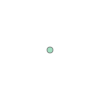

In [60]:
tp[5]

## Function to make three buffered line sections from a single linestring

Takes a linestring input, creates 6 points and then three buffered lines from each pair of points aligned to linestring. Outputs list of three buffered line geometries, ready to be intersected with polygon until one shows enough overlap to conclude there is parking potential.

In [61]:
def three_buff_lines(ls):
    #get six points from linestring
    pts = six_pts(ls)
    #split list into pairs of start and end points 
    start_pts = pts[::2]
    end_pts = pts[1::2]
    
    #init buffered linestring list: bls_list
    bls_list = []
    
    for i in np.arange(len(start_pts)):
        #buffered linestring: bls
        bls = (
            shp.geometry.LineString([start_pts[i], end_pts[i]]) #create linestring
            .buffer(distance = 4.8, cap_style = 2) #buffer it to 4.8 m
        )
        
        #append to bls_list
        bls_list.append(bls)
    
    return(bls_list) 


In [62]:
r = three_buff_lines(ls = rsls['geometry'][0])

In [63]:
list(r[2].exterior.coords)

[(519567.78783717926, 180932.63377475867),
 (519569.21216282074, 180923.1400243687),
 (519566.83874210867, 180922.78394549162),
 (519565.4144164672, 180932.27769588158),
 (519567.78783717926, 180932.63377475867)]

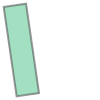

In [64]:
r[0]

## Use test_set of linestrings/TOIDs to set up loop

Steps
- initiate potential_parking list to hold TOIDs that have parking
- loop through individual linestrings row by row from rsls
- create 3 buffered line segments from linestring
- collect TOID the linestring is associated with
- collect polygons from exvms with same TOID into a small gdf
- compare each buffered line segment to small gdf, keep only rows where there is intersection
     - iterate through buffered line segments
     - calculated area of intersection
     - area of intersection / (2.4 * 4.8)
     - area of intersection / polygon area
- 

Select some linestrings. These need to include examples of TOIDs single/mulitple linestrings and single/multiple polygons. These are the possible combinations
- TOID has single linestring & single polygon
    - 1000001778697489, 1000001778697540
- TOID has single linestring & multiple (disjoint) polygons. In this case the linestring intersects with only one of the polygons, the other polygons have no roadside intersection, they got reincluded when I did the dissolve by TOID). 
    - 1000001778697935, 1000001778697845, 1000001778697638
- TOID has multiple (disjoint) linestrings & single polygon
    - 1000001778697829, 1000001778697815
- TOID has multiple (disjoint) linestrings & multiple (disjoint) polygons
    - 1000001778697506, 1000001778702208, 1000001778702275

In [65]:
big_test_toid_list = [
    '1000001778697489', '1000001778697540'
    , '1000001778697935', '1000001778697845', '1000001778697638'
    , '1000001778697829', '1000001778697815'
    , '1000001778697506' , '1000001778702208', '1000001778702275'
]

In [66]:
small_test_toid_list = [
    '1000001778697489'
    , '1000001778697935'
    , '1000001778697829'
    , '1000001778697506'
]

In [67]:
small_rsls = (
    rsls[ rsls.TOID.isin(small_test_toid_list) ]
    .reset_index(drop = True)
    .drop(['rslsLength'], axis = 1)
    .sort_values(by = ['TOID'])
)
small_rsls

TOID                                           geometry
5  1000001778697489  LINESTRING (519613.200 180877.100, 519617.000 ...
2  1000001778697506  LINESTRING (519925.500 180706.400, 519925.900 ...
3  1000001778697506  LINESTRING (519944.000 180697.013, 519945.900 ...
0  1000001778697829  LINESTRING (519563.150 180927.100, 519566.950 ...
1  1000001778697829  LINESTRING (519573.000 180928.575, 519578.400 ...
4  1000001778697935  LINESTRING (519854.893 180641.000, 519853.580 ...

In [68]:
small_exvms = exvms[exvms.TOID.isin( small_test_toid_list )].sort_values(by = ['TOID'])
small_exvms

TOID                                           geometry
19   1000001778697489  POLYGON ((519614.500 180876.000, 519614.000 18...
21   1000001778697506  POLYGON ((519944.000 180697.500, 519944.500 18...
22   1000001778697506  POLYGON ((519925.500 180706.500, 519926.500 18...
105  1000001778697829  POLYGON ((519575.500 180929.500, 519575.500 18...
157  1000001778697935  POLYGON ((519833.500 180637.500, 519835.000 18...
158  1000001778697935  POLYGON ((519847.000 180644.500, 519848.000 18...
159  1000001778697935  POLYGON ((519810.000 180666.500, 519810.500 18...

### small_test_toid_list & small_rsls

Contains 4 TOIDs, 6 linestrings, 7 polyons and one example of each combination. Reset index on **small_rsls** because I want to loop through the rsls df by row.

### Look at individual plots

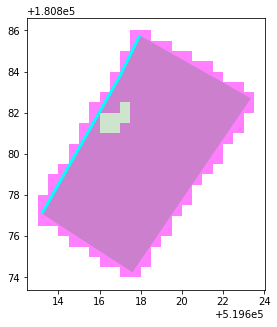

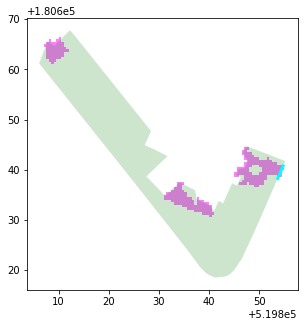

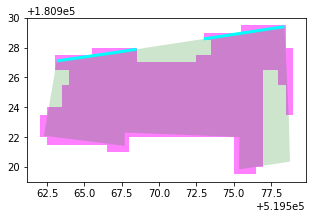

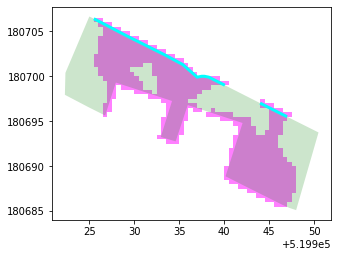

In [69]:
for toid in small_test_toid_list:
    base = exvms[ exvms['TOID'] == toid ].plot(color = 'magenta', figsize = (5,5), alpha = 0.5)
    rsls[ rsls['TOID'] == toid ].plot(ax = base, linewidth = 3, color = 'cyan')
    cg[ cg['gdnTOID'] == toid ].plot(ax = base, color = 'green', alpha = 0.2)

## Attempt 1 - FAIL !!!

- by toid and by linestring
- uses rsls and exvms
- udf three_buff_lines

In [233]:
#init parking potential list: pp_list
#to hold TOIDs that havehtis property
pp_list = []

for toid in small_test_toid_list:
    
    #might need to move this into the ls checking loop
    if toid in pp_list:
        continue #skip toid if it has already been tested and found adequate
    
    #get list of linestrings from rsls
    ls_list = rsls[rsls['TOID'] == toid]['geometry']
     
    #iterate through linestrings
    for  ls in ls_list:
        #init list of 3 buffered lines per linesstring
        bls_list = []
        #buffered lines list of three shapes to check
        bls_list.append( three_buff_lines(ls) )
        
        
        
        
        print(list(ls.coords))

[(519613.2000000002, 180877.0999999996), (519617.0, 180883.8000000007), (519617.9479999999, 180885.7530000005)]
[(519854.8934306574, 180641.0), (519853.5795620442, 180638.0)]
[(519563.1500000004, 180927.0999999996), (519566.9500000002, 180927.6500000004), (519568.5, 180927.8868995637)]
[(519573.0, 180928.5746724894), (519578.4000000004, 180929.4000000004)]
[(519925.5, 180706.3999999999), (519925.9000000004, 180706.1999999993), (519929.0499999998, 180704.5500000007), (519933.5499999998, 180702.3000000007), (519935.4000000004, 180701.3000000007), (519937.0, 180699.9000000004), (519937.5, 180700.0), (519937.7999999998, 180700.0), (519938.2999999998, 180699.9000000004), (519940.0766233775, 180699.0)]
[(519944.0, 180697.0125000007), (519945.9000000004, 180696.0500000007), (519947.000000001, 180695.5)]


In [244]:
small_test_toid_list

['1000001778697489',
 '1000001778697935',
 '1000001778697829',
 '1000001778697506']

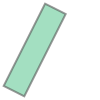

In [256]:
bls_list[1][2]
#bls_list is a list of lists

In [264]:
exvms[exvms['TOID'] == toid]['geometry']

21    POLYGON ((519944.000 180697.500, 519944.500 18...
22    POLYGON ((519925.500 180706.500, 519926.500 18...
Name: geometry, dtype: geometry

In [229]:
ls_list.length

551    16.574735
552     3.359721
dtype: float64

## Attempt 2

- creates 3 rectangles, aligned left, middle, right for each linestring to test

by rsls linestring
- use small_rsls, small_exvms, small_test_toid_list
- iterate through rows of small_rsls; 

### Number of rows to expect in output
- We produce 3 rectangles from each line string: in small_rsls that is 6 linestrings, so 3 * 16 = 18
- then for each of these 18 rectangles we compare with all the polygons associated with the TOID, not just the one that the linestring intersects with.
- in small_exvms we have 7 polygons
- overall there are only 4 TOIDs in this experiment

#### So how many rows to expect in the output?
For each toid (sum of (number of linesstrings * number of polygons * 3 rectangles))

$1*1*3 + 1*3*3 + 2*1*3 + 2*2*3 = 3 + 9 + 6 + 12 = 30$

$3(1*1 + 1*3 + 2*1 + 2*2) = 3(1 + 3 + 2 + 4) = 3 * 10 = 30$

### Function to calculate the total number of outputs to expect (before dropping empty polygons)

Takes 3 inputs
- toid list
- gdf/df of linestrings with toid coloumn
- gdf/df of vms polygons with toid coloumn

In [230]:
def calc_num_out(ls_gdf, vms_gdf):

    total_outputs = 0
    
    #create toid list from gdfs
    toid_list = ls_gdf['TOID'].drop_duplicates().tolist()

    for toid in toid_list:
        #get number of linestrings for that TOID
        toid_ls_num = ls_gdf[ls_gdf['TOID'] == toid].shape[0]
        #get number of vms polygons for that TOID
        toid_vms_num = vms_gdf[vms_gdf['TOID'] == toid].shape[0]
    
        #find number of outputs for this toid and add to total
        total_outputs += 3 * toid_ls_num * toid_vms_num
    
    return total_outputs  

In [231]:
calc_num_out(
    ls_gdf = small_rsls
    , vms_gdf = small_exvms

)

30

In [233]:
gdf_list = []

for index, row in small_rsls.iterrows():
    
    toid = row['TOID'] #get toid
    ls = row['geometry'] #get single linestring
    rec_list = three_buff_lines(ls) #list of three rectangles for this linestring
    int_list = [] #init intersection list to hold resulting polygons from intersection
    
    #for each rec find intersection and append to int_list
    for rec in rec_list:
        int_list.append(
            small_exvms[ small_exvms['TOID'] == toid ]['geometry']
            .intersection( rec )
        ) 
    
    #for each ls set of int_list make gdf and append to list of gdf
    gdf_list.append( 
        gpd.GeoDataFrame(
        {'TOID' : toid, 'geometry': pd.concat(int_list)} #create dict from toid and int geomtery
        , crs = "EPSG:27700", geometry = "geometry") #make gdf from d
    )
    
test_gdf = pd.concat(gdf_list)
test_gdf = test_gdf[~test_gdf['geometry'].is_empty]
test_gdf.head()

TOID                                           geometry
19  1000001778697489  POLYGON ((519613.000 180877.213, 519613.000 18...
19  1000001778697489  POLYGON ((519614.780 180880.500, 519615.000 18...
19  1000001778697489  POLYGON ((519616.500 180883.792, 519616.500 18...
22  1000001778697506  POLYGON ((519925.552 180706.500, 519926.500 18...
22  1000001778697506  MULTIPOLYGON (((519931.976 180703.500, 519932....

In [218]:
test_gdf.shape

(19, 2)

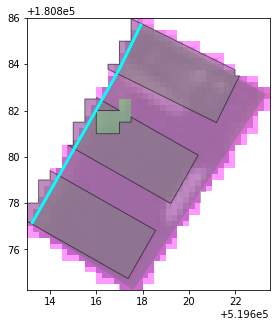

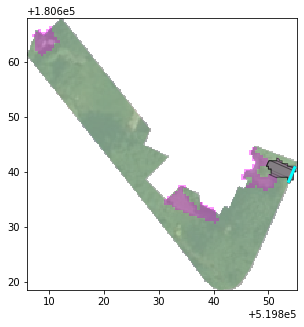

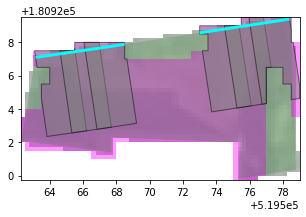

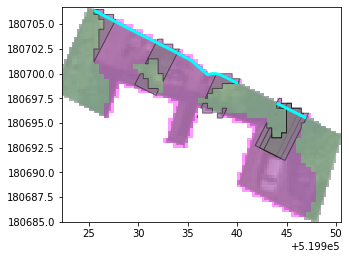

In [72]:
grid = 'TQ1980'

for toid in small_test_toid_list:
    
    base = exvms[ exvms['TOID'] == toid ].plot(color = 'magenta', figsize = (5,5), alpha = 0.4)
    rsls[ rsls['TOID'] == toid ].plot(ax = base, linewidth = 3, color = 'cyan')
    cg[ cg['gdnTOID'] == toid ].plot(ax = base, color = 'green', alpha = 0.2)
    test_gdf[ test_gdf['TOID'] == toid ].plot(ax = base, color = 'grey', edgecolor = 'black', alpha = 0.5)
    
    rgb_path = '../jigsaw_output/rgb_gdn_cropped/' + grid + "_" + toid + '.tif'
    rgb = rasterio.open(rgb_path)
    plot.show(rgb, ax = base, alpha = 0.5)
    

## Clearly some problems with this method of the three rectangles

### Run on full rsls gdf anyway

- final image shows by choosing only three position, left, middle, right does not try to fit car in the one place that there is a space. 
- Also got some multipolygons were foilage completely cuts off the middle of the rectangle. These don't matter
- Look at third rectangle from top left in last plot above. This is made up of three individual polygons, but will actually only take 2 rows. The 2 left most polygons are a multipolygon geometry that intersects with the top vms, and the final piece is a single polygon that intersects with the bottom vms. This is rare, so not much of a problem.

- anyway lets try it on the full data set of 1055 linestrings, should get 3339 rows before dropping empty polygons. Have checked that this is correct. 
 
- need to build in stops when toid has been tagged as parking potential exists.

In [234]:
print("Expected number of outputs before dropping any empty polygons: "
     , calc_num_out(ls_gdf = rsls, vms_gdf = exvms)
     )

Expected number of outputs before dropping any empty polygons:  3339


In [236]:
gdf_list = []

for index, row in rsls.iterrows():
    
    toid = row['TOID'] #get toid
    ls = row['geometry'] #get single linestring
    rec_list = three_buff_lines(ls) #list of three rectangles for this linestring
    int_list = [] #init intersection list to hold resulting polygons from intersection
    
    #for each rec find intersection and append to int_list
    for rec in rec_list:
        int_list.append(
            exvms[ exvms['TOID'] == toid ]['geometry']
            .intersection( rec )
        ) 
    
    #for each ls set of int_list make gdf and append to list of gdf
    gdf_list.append( 
        gpd.GeoDataFrame(
        {'TOID' : toid, 'geometry': pd.concat(int_list)} #create dict from toid and int geomtery
        , crs = "EPSG:27700", geometry = "geometry") #make gdf from d
    )
    
recs = pd.concat(gdf_list)
recs = recs[~recs['geometry'].is_empty] #got 3339 rows before dropping empty polygons - as expected
recs.head()

TOID                                           geometry
105  1000001778697829  POLYGON ((519563.092 180927.500, 519565.000 18...
105  1000001778697829  POLYGON ((519564.612 180927.500, 519565.000 18...
105  1000001778697829  POLYGON ((519568.500 180927.887, 519568.500 18...
105  1000001778697829  POLYGON ((519573.000 180928.575, 519573.000 18...
105  1000001778697829  POLYGON ((519574.484 180929.000, 519575.000 18...

In [237]:
recs.shape

(3169, 2)

(180800, 180900)

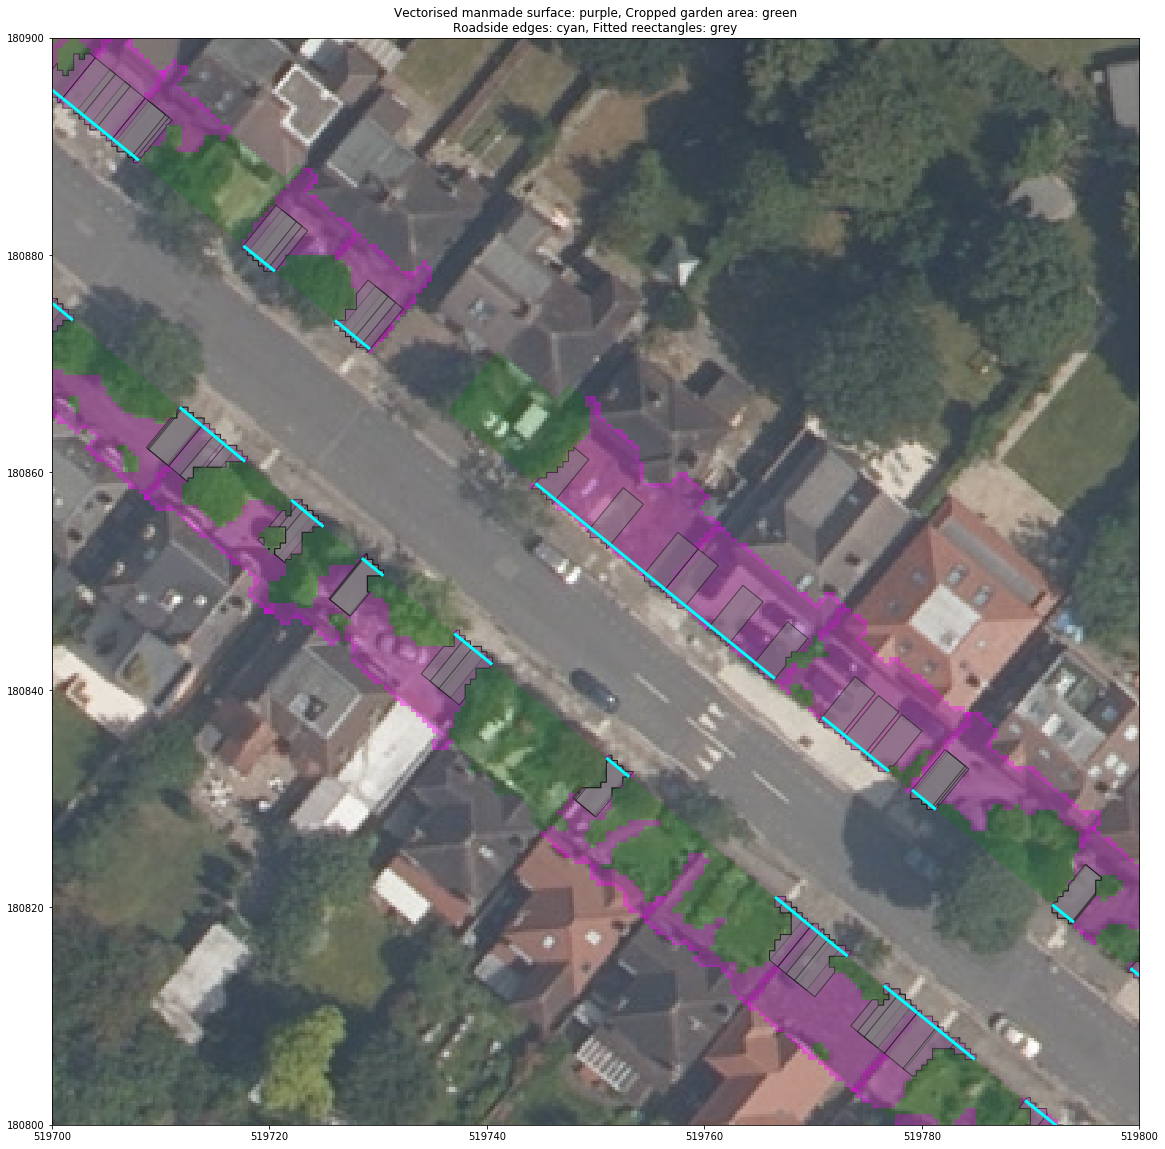

In [301]:
base = exvms.plot(color = 'magenta', figsize = (20,20), alpha = 0.4)
rsls.plot(ax = base, linewidth = 3, color = 'cyan')
cg.plot(ax = base, color = 'green', alpha = 0.2)
recs.plot(ax = base, color = 'grey', edgecolor = 'black', alpha = 0.5)
plot.show(rgb1980, ax = base)

base.set_title("Vectorised manmade surface: purple, Cropped garden area: green" + 
               "\nRoadside edges: cyan, Fitted rectangles: grey")

base.set_xlim(519700, 519800)
base.set_ylim(180800, 180900)

### Look at proportion of area of overlap of each rectangle

Proportion of the rectangle size, 11.52 sqm that intersects with the vms.

There are some proportions here greater than 1, because the vectorised manmade surface pixels stick out beyond the original cropped garden image and since the rectangles are created using a buffered linestring then have area either side of the roadside edge. 

I could fix this easily by intersecting again with the cropped garden polygons of the same TOID, but it's a small area and cars may slightly stick out from the driveway anyway, so I don't think it's a big problem for now.

Note that **recs** includes all the rectangles that were 

In [239]:
rec_area = 2.4 * 4.8 

recs['prop_of_rec'] = (
    recs['geometry'].apply(lambda x: x.area / rec_area )
)

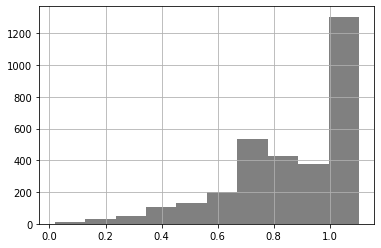

In [240]:
recs['prop_of_rec'].hist(bins = 10, color = 'grey')

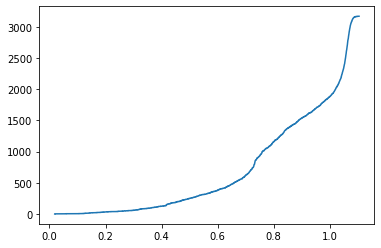

In [241]:
#Cumulative sum graph
#x-axis: proportion values 0 to slightly over 1
#y-axis: number of rows
sorted_data = np.sort(recs['prop_of_rec'])  # Or data.sort(), if data can be modified
# Cumulative counts:
plt.step(sorted_data, np.arange(sorted_data.size))  # From 0 to the number of data points-1
#plt.step(sorted_data[::-1], np.arange(sorted_data.size))  # From the number of data points-1 to 0

plt.show()

In [242]:
recs.describe()

prop_of_rec
count  3169.000000
mean      0.861067
std       0.214898
min       0.018541
25%       0.730813
50%       0.918197
75%       1.051512
max       1.104666

In [243]:
recs.shape

(3169, 3)

In [244]:
#reset index
recs = recs.reset_index(drop = True)

In [245]:
recs.head()

TOID                                           geometry  \
0  1000001778697829  POLYGON ((519563.092 180927.500, 519565.000 18...   
1  1000001778697829  POLYGON ((519564.612 180927.500, 519565.000 18...   
2  1000001778697829  POLYGON ((519568.500 180927.887, 519568.500 18...   
3  1000001778697829  POLYGON ((519573.000 180928.575, 519573.000 18...   
4  1000001778697829  POLYGON ((519574.484 180929.000, 519575.000 18...   

   prop_of_rec  
0     0.983936  
1     1.067739  
2     1.056203  
3     1.014451  
4     0.978213

In [246]:
#write to file 
recs.to_csv("../parking_output/parking_recs_attempt_2.csv", index=False)

## How to decide a cut off threshold 

Using the prop_of_rec column I can decide a cut off proportion. Initially I thought to use the median, 0.91 but this is arbitrary, it is just the point where half the data is either side of. 

### 90%
90% cut off is justifiable I think. This is 10 sqm and allows some wiggle room for partially overlapping foliage and shorter, narrower cars. 

Although consider that the vms area partly sticks out over the rsls, because of the buffering method to create the rectangle, so there is a small amount of extra space here. So this means I should have a higher cut off to account for this extra space

I need to look at the number of toids that get labelled as parking at each different cut off and plot these. Say for a few values, 1, 0.9, 0.8. And compare to the manual labels I suppose.

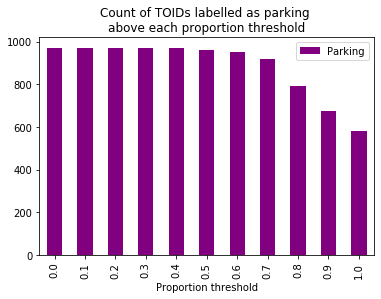

In [295]:
toid_counts = []

for t in np.arange(0, 1.1, 0.1):
    toid_counts.append( recs[ recs['prop_of_rec'] >= t ]['TOID'].drop_duplicates().shape[0] )

toid_counts

tpc = pd.DataFrame( {'Proportion threshold' : np.arange(0, 1.1, 0.1).round(decimals = 1)
                     , 'Parking' : toid_counts} )

tpc.plot.bar(x = 'Proportion threshold', y = 'Parking', color = 'purple'
        , title = 'Count of TOIDs labelled as parking \nabove each proportion threshold' )

### plot only those with intersection area >= 0.9

In [111]:
threshold = 0.9
print(threshold * 2.4 * 4.8)
#10sqm, 2.5 * 4, 2 * 5... smaller cars will fit here... seems reasonable to include

10.57762944


(180000, 180200)

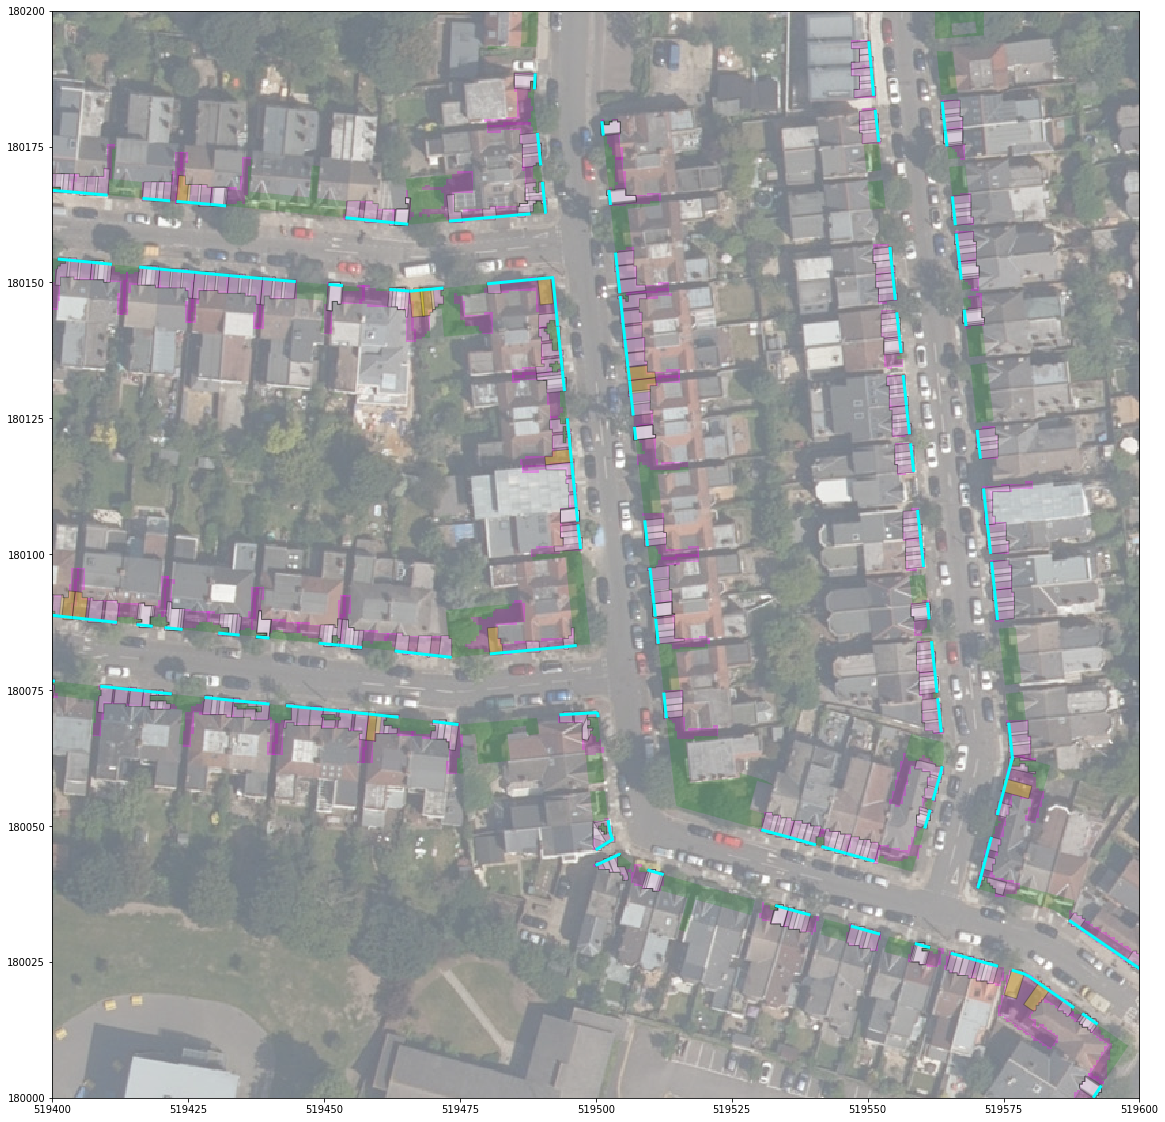

In [302]:
threshold = 0.9

base = exvms.plot(color = 'magenta', figsize = (20,20), alpha = 0.3)
rsls.plot(ax = base, linewidth = 3, color = 'cyan')
cg.plot(ax = base, color = 'green', alpha = 0.2)
recs[ recs['prop_of_rec'] >= threshold ].plot(ax = base, color = 'yellow', edgecolor = 'black', alpha = 0.3)
recs[ recs['prop_of_rec'] < threshold ].plot(ax = base, color = 'white', edgecolor = 'black', alpha = 0.3)

plot.show(rgb1980, ax = base, alpha = 0.7)
base.set_xlim(519400, 519600)
base.set_ylim(180000, 180200)

(180800, 181000)

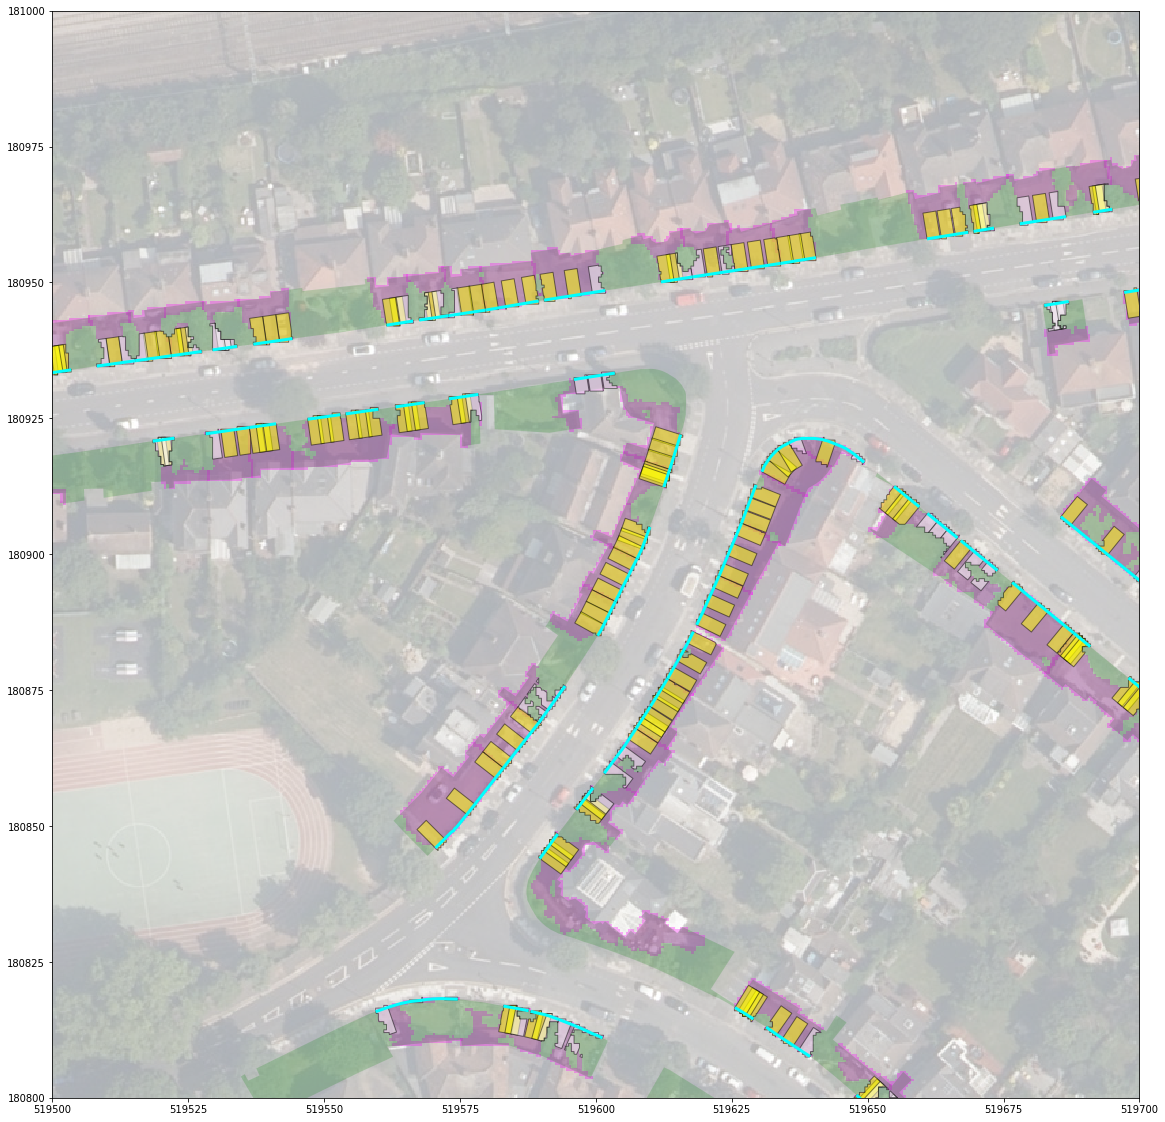

In [297]:
threshold = 0.9

base = exvms.plot(color = 'magenta', figsize = (20,20), alpha = 0.3)
rsls.plot(ax = base, linewidth = 3, color = 'cyan')
cg.plot(ax = base, color = 'green', alpha = 0.2)
recs[ recs['prop_of_rec'] >= threshold ].plot(ax = base, color = 'yellow', edgecolor = 'black', alpha = 0.5)
recs[ recs['prop_of_rec'] < threshold ].plot(ax = base, color = 'white', edgecolor = 'black', alpha = 0.5)

plot.show(rgb1980, ax = base, alpha = 0.4)

base.set_xlim(519500, 519700)
base.set_ylim(180800, 181000)

## Function to create sliding rectangles

- create list/array of midpoints of rectangles
- create lines and buffer to 4.8m
- intersect all rectangles and get area of intersection
- calculate proportion
- keep max
- if max >= 1 label TOID as parking, so we do not try any other linestring from this toid???

Can't decide when to say 

### Create middle points of rectangles 

- will then +- 1.2 to each mid point to get the two points to make a rectangle from

Do not include start and end of line

- get from_start midpoints at 1.2, 1.7, at 0.5 intervals upto half way
- get from_end midpoints by subtracting line length from these
- concatenate and insert the midpoint of the line

In [191]:
from_start = (
    np.arange( start = 1.2, stop = test_line.length / 2, step = 0.5) )

from_start

array([1.2, 1.7, 2.2, 2.7])

In [199]:
from_end = test_line.length - from_start
np.sort(from_end)

array([2.7075955, 3.2075955, 3.7075955, 4.2075955])

In [206]:
rec_mid_pts = np.concatenate(
    ( from_start
     , np.array( test_line.length / 2).reshape(1) #reshape from 0D to 1D array
     , np.sort(from_end) )
)
rec_mid_pts

array([1.2       , 1.7       , 2.2       , 2.7       , 2.70379775,
       2.7075955 , 3.2075955 , 3.7075955 , 4.2075955 ])

In [194]:
test_line.length / 2

2.703797752299053

In [196]:
test_line.length

5.407595504598106

In [ ]:
#join start, middle and end of arrays together in order

In [202]:
from_start.shape

(4,)

In [205]:
np.array( test_line.length / 2).reshape(1).shape

(1,)

## NEXT

- work out proportions look at distribution: rec overlap area / rec (11.52)

- rework rectangle generation to use sliding rectangle, every 0.5 m, but must build in point to stop at, and keep only that rectangle that fit


- DONE

- write up


# ARCHIVE

In [8]:
vms_orig = pd.read_csv(
    "../data/vms_original.csv"
    , dtype={'TOID': object, 'geometry': object})
#### convert WKT strings to geometry
vms_orig['geometry'] = vms_orig['geometry'].map(shp.wkt.loads)
#### convert to geodataframe and set CRS
vms_orig = gpd.GeoDataFrame(vms_orig, crs="EPSG:27700", geometry="geometry")

In [18]:
vms_orig.shape

(2626, 2)

(180800, 180900)

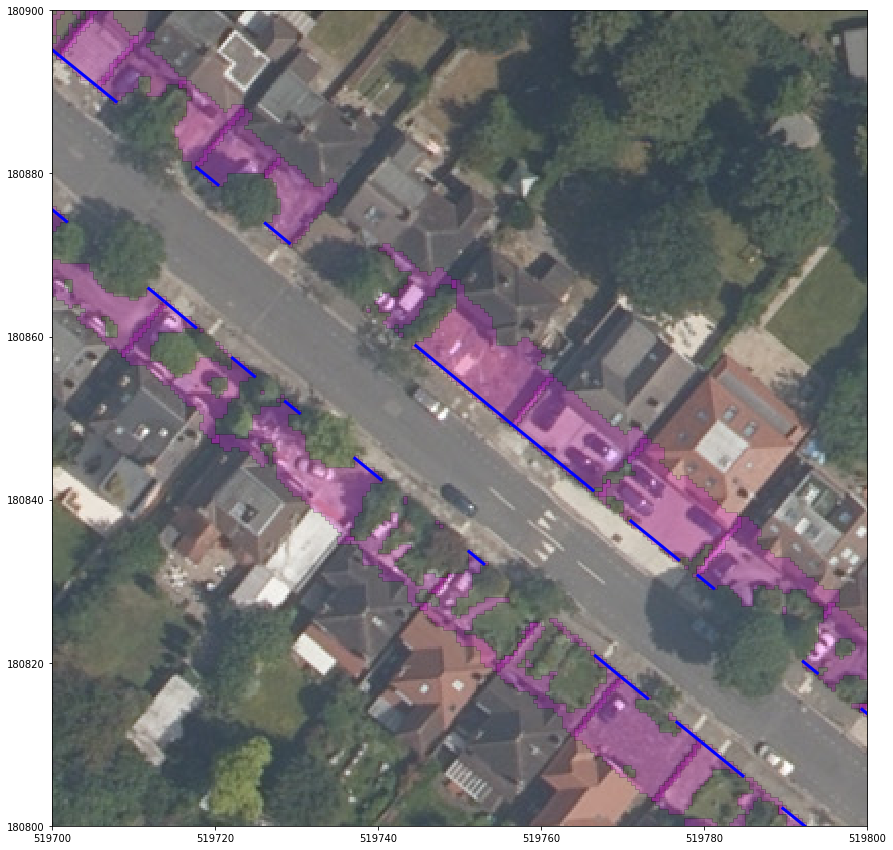

In [17]:
base = vms_orig.plot(figsize = (15,15), color = 'magenta', edgecolor = 'black', linewidth = 1, alpha = 0.2)
rsls.plot(ax = base, color = 'blue', linewidth = 3)
plot.show(rgb1980, ax = base)
base.set_xlim(519700, 519800)
base.set_ylim(180800, 180900)

In [12]:
#roadside_linestrings.csv contains cropped garden roadside linestring, not interesected with VMS
rsls_orig = pd.read_csv(
    "../data/roadside_linestrings.csv"
    , dtype={'gdnTOID': object, 'rsTOID': object, 'geometry': object})
#### convert WKT strings to geometry
rsls_orig['geometry'] = rsls_orig['geometry'].map(shp.wkt.loads)
#### convert to geodataframe and set CRS
rsls_orig = gpd.GeoDataFrame(rsls_orig, crs="EPSG:27700", geometry="geometry")

In [15]:
rsls_vms = pd.read_csv(
    "../data/rsEdge.csv"
    , dtype={'TOID': object,'DescriptiveGroup': object,'SHAPE_Length': object
             , 'SHAPE_Area': object, 'rsTOID': object, 'geometry': object})
#### convert WKT strings to geometry
rsls_vms['geometry'] = rsls_vms['geometry'].map(shp.wkt.loads)
#### convert to geodataframe and set CRS
rsls_vms = gpd.GeoDataFrame(rsls_vms, crs="EPSG:27700", geometry="geometry")

(180800, 180900)

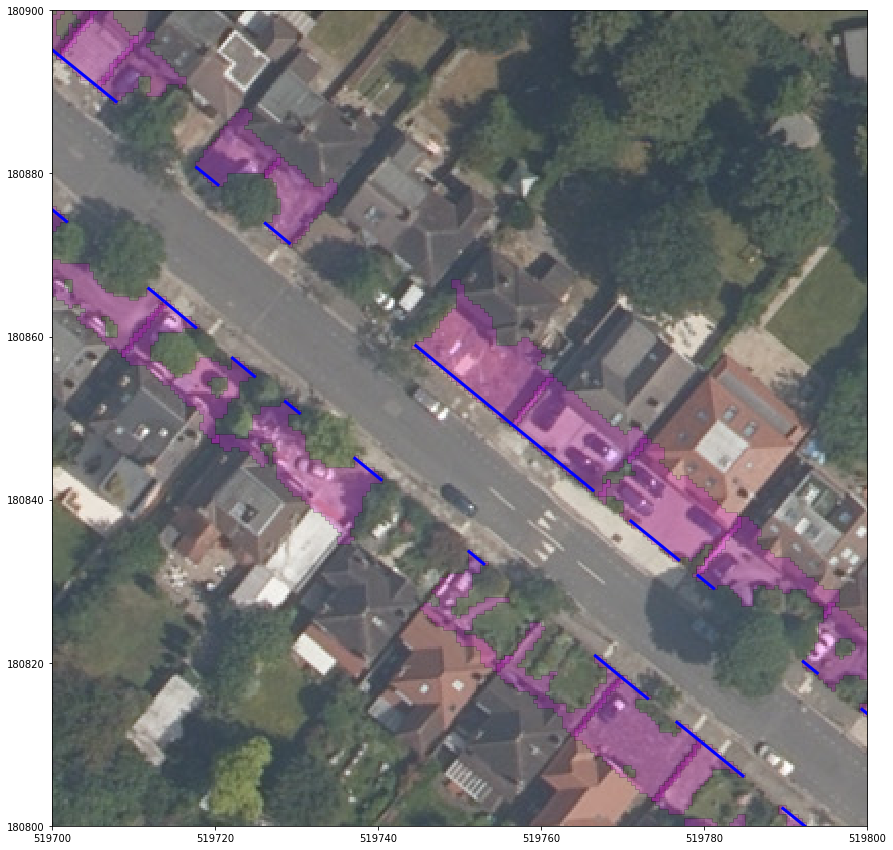

In [10]:
base = dhvms.plot(figsize = (15,15), color = 'magenta', edgecolor = 'black', linewidth = 1, alpha = 0.2)
rsls.plot(ax = base, color = 'blue', linewidth = 3)
plot.show(rgb1980, ax = base)
base.set_xlim(519700, 519800)
base.set_ylim(180800, 180900)

## Collect toids with parking - moved to ppp16

In [125]:
parking_toids = recs[recs['parking'] == 1]['TOID'].drop_duplicates().tolist()

In [132]:
len(parking_toids)

658

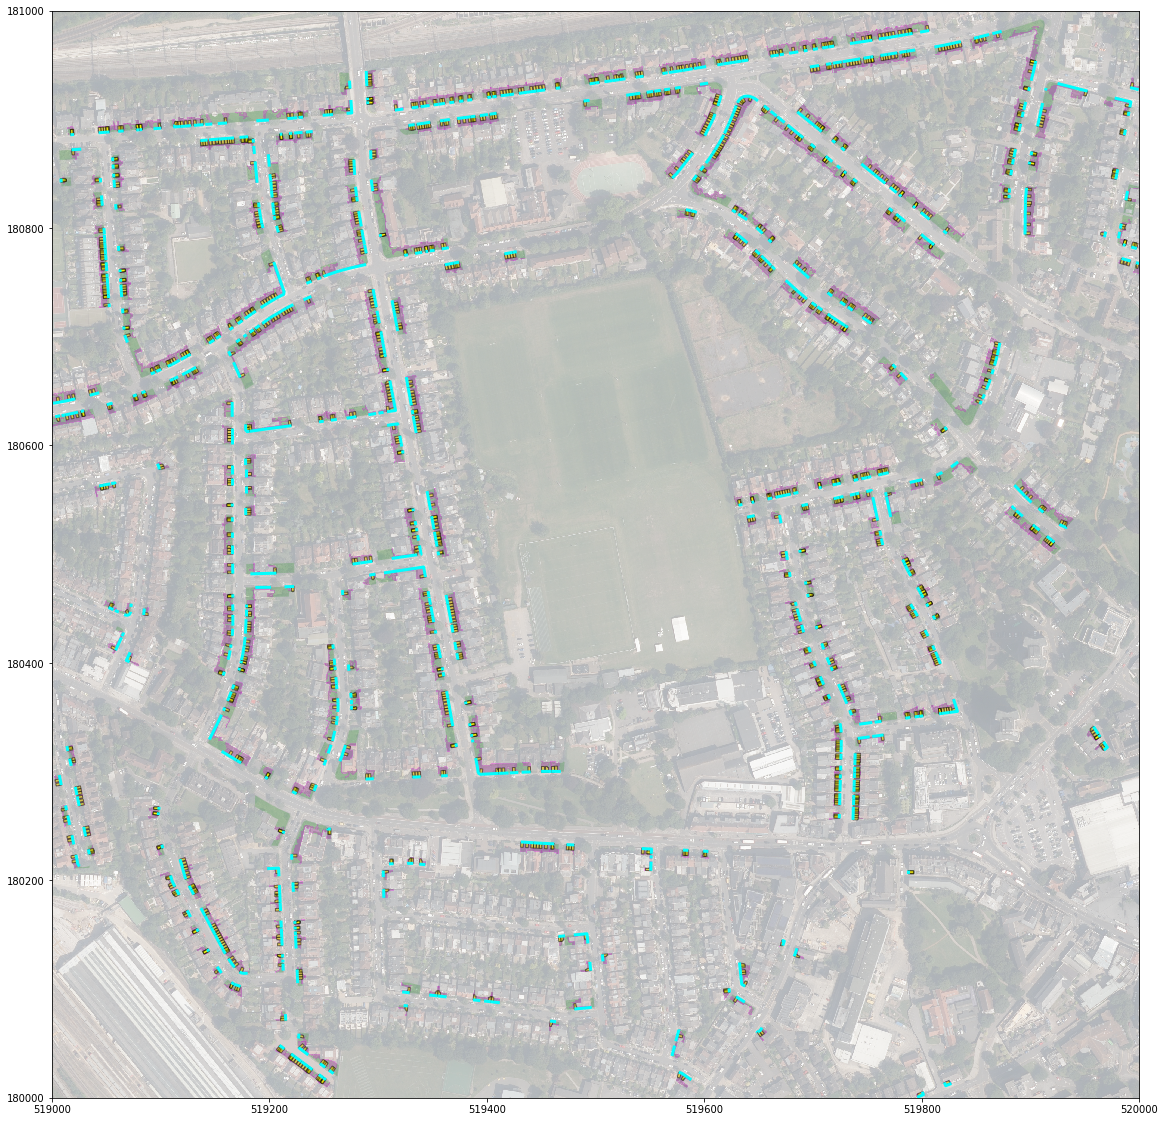

In [130]:
base = exvms[ exvms.TOID.isin(parking_toids) ].plot(color = 'magenta', figsize = (20,20), alpha = 0.3)
rsls[ rsls.TOID.isin(parking_toids) ].plot(ax = base, linewidth = 3, color = 'cyan')
cg[ cg.gdnTOID.isin(parking_toids) ].plot(ax = base, color = 'green', alpha = 0.2)
recs[ recs['prop_of_rec'] >= threshold ].plot(ax = base, color = 'yellow', edgecolor = 'black', alpha = 0.5)

plot.show(rgb1980, ax = base, alpha = 0.4)

In [147]:
test_line.length // 0.5

10.0

In [150]:
np.linspace(0, (test_line.length / 2), num = int( (test_line.length / 2) // 0.5 ), retstep = True)

(array([0.        , 0.67594944, 1.35189888, 2.02784831, 2.70379775]),
 0.6759494380747633)

In [152]:
np.linspace(0, 12, num = int( (12 / 2) // 0.5 ), retstep = True)

(array([ 0.        ,  1.09090909,  2.18181818,  3.27272727,  4.36363636,
         5.45454545,  6.54545455,  7.63636364,  8.72727273,  9.81818182,
        10.90909091, 12.        ]),
 1.0909090909090908)

In [ ]:
#pass means allow through
#not the same as continue which means to skip an iterant and go to the next
try:
except:
    pass

## NEXT

- work out how to fix invalid polygons
- go back to vms creation in ppp13 and check for validity there
- continue with sliding position rectangles 

## INVALID polygons

I have 30 invalid polygons, they appear to intersect themselves, but these were not classed as holes. I guess because they occur on the edge of the polygon. 

I NEED TO CHECK VMS for valid polygons when it is created

I think these have been here since the raster manmade surfaces were vectorised. Major problem, did not notice it then, because I hadn't tried intersection with any of them by chance. Did do dissolve though, when filling small holes, that did not seem to be bothered by them. 

In [403]:
invalid_pol_toids = exvms[ exvms['geometry'].is_valid == False ]['TOID']

In [404]:
len(invalid_pol_toids)

30

In [405]:
invalid_pol_toids[0:5]

57     1000001778697647
60     1000001778697654
102    1000001778697820
127    1000001778697865
146    1000001778697899
Name: TOID, dtype: object

In [394]:
#this is not to do with the explosion of mulitpolygon then
#possibly to do with the filling of holes?
( exvms[ exvms['geometry'].is_valid == False ]['TOID']
 .sort_values().tolist() == dhvms[ dhvms['geometry']
                         .is_valid == False ]['TOID'].sort_values().tolist()
)

True

(180700, 180750)

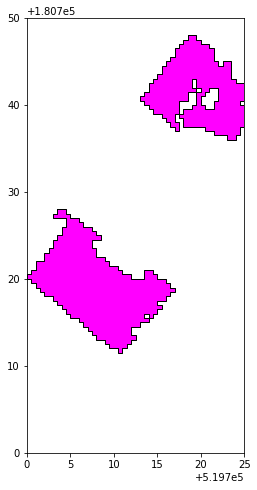

In [400]:
base = ( dhvms[ dhvms['geometry'].is_valid == False ]
        .plot(color = 'magenta', edgecolor = 'black', figsize = (8, 8)) )
base.set_xlim(519700, 519725)
base.set_ylim(180700, 180750)

## Fix invalid polygons

https://stackoverflow.com/questions/20833344/fix-invalid-polygon-in-shapely

create a buffer of 0 m

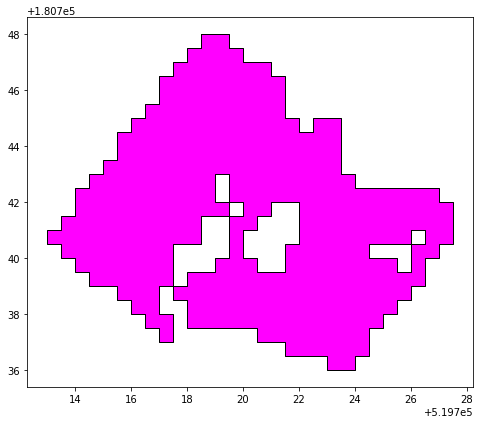

In [408]:
toid = '1000001778697647'

base = ( exvms[ exvms['TOID'] == toid ]
        .plot(color = 'magenta', edgecolor = 'black', figsize = (8, 8)) )

In [410]:
p = exvms[ exvms['TOID'] == toid ]['geometry']

In [411]:
p.is_valid

57    False
dtype: bool

In [412]:
p2 = p.buffer(0)

In [413]:
p2.is_valid

57    True
dtype: bool

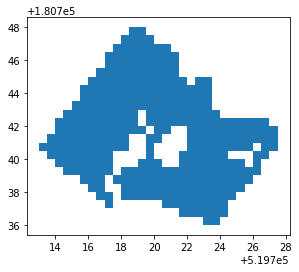

In [417]:
p2.plot()

In [419]:
p.area == p2.area

57    True
dtype: bool

In [349]:
a = pd.concat(int_list)
d = {'geometry': a}
test_gdf = gpd.GeoDataFrame(d, crs="EPSG:27700", geometry="geometry")
#drop empty rows
test_gdf = test_gdf[~test_gdf['geometry'].is_empty]

In [344]:
#flatten a list of lists
flattened_list = [y for x in all_int_list for y in x]

a = pd.concat(flattened_list)
d = {'geometry': a}
test_gdf = gpd.GeoDataFrame(d, crs="EPSG:27700", geometry="geometry")
#drop empty rows
test_gdf = test_gdf[~test_gdf['geometry'].is_empty]

In [239]:
#set random seed and choose 5 TOIDs 
np.random.seed(seed=314159)

test_toid_list = np.random.choice(
    dhvms.TOID.tolist()
    , 5
).tolist()

In [128]:
#split list into 2 lists at every other element
#list slicing
a = [0,1,2,3,4,5]
b = a[::2]
c = a[1::2]
print(b)
print(c)

[0, 2, 4]
[1, 3, 5]


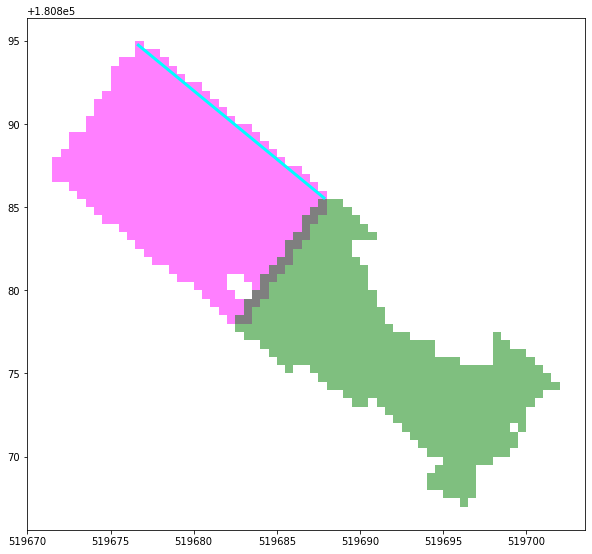

In [86]:
# ERROR when I used 'intersects' for the spatial join picked up neighbuoring gardens as touching
# the end of the rsls. Hopefully fixed this by using 'within'
base = exvms[ exvms['TOID'] == '5000005138038971' ].plot(color = 'magenta', figsize = (10,10), alpha = 0.5)
rsls[ rsls['TOID'] == '5000005138038971' ].plot(ax = base, linewidth = 3, color = 'cyan')
exvms[ exvms['TOID'] == '1000001778697820' ].plot(ax = base, color = 'green', alpha = 0.5)
#cg[ cg.gdnTOID.isin(mplist[0:5]) ].plot(ax = base, color = 'green', alpha = 0.2)
#base.set_xlim(519800, 519860)
#base.set_ylim(180615, 180670)

## parallel_offset

https://shapely.readthedocs.io/en/latest/manual.html#object.parallel_offset

Left and right are determined by following the direction of the given geometric points of the LineString. Right hand offsets are returned in the reverse direction of the original LineString or LineRing, while left side offsets flow in the same direction.

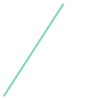

In [222]:
rsls['geometry'][3].parallel_offset(
    distance = 2
    , side = 'left'
    , resolution = 16
    , join_style = 2
    , mitre_limit = 10.0
)

In [69]:
type(offsets)

geopandas.geoseries.GeoSeries

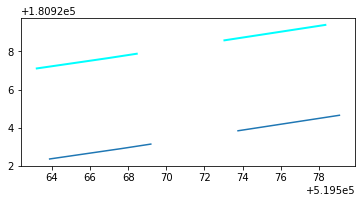

In [73]:
toid = "1000001778697829"
#lambda function
offsets = rsls[rsls['TOID'] == toid]['geometry'].apply(lambda x: x.parallel_offset(
    distance = 4.8
    , side = 'right'
    , resolution = 16
    , join_style = 2
    , mitre_limit = 10.0
))

gdf = gpd.GeoDataFrame(offsets, crs="EPSG:27700", geometry="geometry")

#plot both
base = rsls[rsls['TOID'] == toid].plot(color = 'cyan', linewidth = 2)
gdf.plot(ax = base)

In [70]:
gdf

geometry
0  LINESTRING (519560.285 180946.894, 519564.007 ...
1  LINESTRING (519569.978 180948.345, 519575.378 ...

## Shapely shape attributes

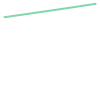

In [15]:
rsls['geometry'][0]

In [14]:
rsls['geometry'][0].bounds
#for a straight line can I assume these are the end points? 

(519563.1500000004, 180927.0999999996, 519568.5, 180927.8868995637)

In [23]:
len(rsls['geometry'][0].coords)
#number of points in linestring (all are unique)

3

In [17]:
list(rsls['geometry'][0].coords)
#list defining coords of linestring

[(519563.1500000004, 180927.0999999996),
 (519566.9500000002, 180927.6500000004),
 (519568.5, 180927.8868995637)]

In [22]:
#slice coords, this line has 3 
rsls['geometry'][0].coords[0:2]

[(519563.1500000004, 180927.0999999996),
 (519566.9500000002, 180927.6500000004)]

## Minimum rotated rectangle

https://shapely.readthedocs.io/en/latest/manual.html#object.minimum_rotated_rectangle

This is the minimum rectangle that contains the shape

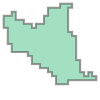

In [36]:
index_num = 3

dhvms['geometry'][index_num]


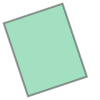

In [37]:
dhvms['geometry'][index_num].minimum_rotated_rectangle